# Classificação de Dígitos MNIST com Modelos Lineares

### Trabalho Prático — Disciplina de Aprendizagem de Máquina

**Participantes:**
- Paulo Victor Cordeiro Rufino de Araújo
- Pedro Lucas Simões Cabral

---

## Objetivo
Implementar e comparar três algoritmos de classificação linear para reconhecimento de dígitos manuscritos (MNIST):
- **Pocket Perceptron**
- **Regressão Linear** (como classificador)
- **Regressão Logística** (Gradiente Descendente Estocástico)

O projeto está dividido em duas etapas:
1. **Classificação binária** — Dígito 1 × Dígito 5
2. **Classificação multiclasse** — Dígitos {0, 1, 4, 5} usando a estratégia **One vs All**

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from models import PocketPerceptron, LinearRegression, LogisticRegression, OneVsAll
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)

## 2. Carregamento do Dataset

Os dados vêm de um **subconjunto do MNIST** contendo apenas os dígitos **0, 1, 4 e 5**.

Cada arquivo CSV possui **785 colunas**:
| Coluna | Conteúdo |
|--------|----------|
| `0` | **Label** (rótulo do dígito: 0, 1, 4 ou 5) |
| `1` a `784` | **Pixels** da imagem 28×28 (valores de 0 a 255) |

In [2]:
train_df = pd.read_csv("mnist-dataset/train.csv", sep=";")
test_df  = pd.read_csv("mnist-dataset/test.csv",  sep=";")

print(f"Treino: {train_df.shape}")  
print(f"Teste:  {test_df.shape}")

Treino: (2186, 785)
Teste:  (1115, 785)


## 3. Separação de Labels e Imagens

Separamos:
- **Labels** → primeira coluna (o dígito verdadeiro)
- **Pixels** → colunas restantes, reorganizadas em matrizes **28×28** para representar cada imagem

In [3]:
# Labels (primeira coluna)
train_labels = train_df.iloc[:, 0].to_numpy()
test_labels  = test_df.iloc[:, 0].to_numpy()

# Pixels (colunas 1 até 784), reshape para (N, 28, 28)
train_images = train_df.iloc[:, 1:].to_numpy().reshape(-1, 28, 28)
test_images  = test_df.iloc[:, 1:].to_numpy().reshape(-1, 28, 28)

print(f"Shape das imagens de treino: {train_images.shape}")
print(f"Shape das imagens de teste:  {test_images.shape}")

Shape das imagens de treino: (2186, 28, 28)
Shape das imagens de teste:  (1115, 28, 28)


## 4. Extração de Features (Características)

Em vez de usar os 784 pixels diretamente, extraímos **duas features** que resumem cada imagem:

### Intensidade

$$
\text{Intensidade} = \frac{1}{255} \sum_{i,j} \text{pixel}(i,j)
$$

 Mede o **"peso" total** da tinta na imagem. Dígitos como o `1` tendem a ter baixa intensidade (poucos pixels acesos), enquanto o `0` tende a ter alta intensidade.

### Simetria

$$
\text{Simetria} = \text{Simetria}_V + \text{Simetria}_H
$$


- **Simetria Vertical**: compara cada pixel `(i, j)` com seu espelho horizontal `(i, 27-j)`
- **Simetria Horizontal**: compara cada pixel `(i, j)` com seu espelho vertical `(27-i, j)`

 Valores **baixos** indicam imagens mais simétricas; valores **altos** indicam assimetria. O dígito `1` é bastante simétrico verticalmente, por exemplo.

In [4]:
def calcular_intensidade(imagem):
    # soma todos os pixels e divide por 255
    return np.sum(imagem) / 255


def calcular_simetria_v(imagem):
    # simetria vertical: compara coluna j com coluna espelhada (27-j)
    sv = 0
    for i in range(28):
        for j in range(14):
            sv += abs(imagem[i, j] - imagem[i, 27 - j])
    return sv / 255


def calcular_simetria_h(imagem):
    # simetria horizontal: compara linha i com linha espelhada (27-i)
    sh = 0
    for i in range(14):
        for j in range(28):
            sh += abs(imagem[i, j] - imagem[27 - i, j])
    return sh / 255


def calcular_simetria(imagem):
    return calcular_simetria_v(imagem) + calcular_simetria_h(imagem)

## 5. Cálculo das Features para Treino e Teste

Aplicamos as funções de **intensidade** e **simetria** a cada uma das imagens dos conjuntos de treino e teste.

Após este passo, cada imagem 28×28 é representada por apenas **2 valores numéricos**.

In [5]:
print("Calculando features de treino...")
train_intensidade = np.array([calcular_intensidade(img) for img in train_images])
train_simetria    = np.array([calcular_simetria(img)    for img in train_images])

print("Calculando features de teste...")
test_intensidade  = np.array([calcular_intensidade(img) for img in test_images])
test_simetria     = np.array([calcular_simetria(img)    for img in test_images])

print("Feito!")

Calculando features de treino...
Calculando features de teste...
Feito!


## Normalização dos dados

In [6]:
scaler = StandardScaler()

train_features = scaler.fit_transform(
    np.column_stack([train_intensidade, train_simetria])
)
test_features = scaler.transform(
    np.column_stack([test_intensidade, test_simetria])
)

train_intensidade, train_simetria = train_features[:, 0], train_features[:, 1]
test_intensidade,  test_simetria  = test_features[:, 0],  test_features[:, 1]

print(f"Intensidade treino — média: {train_intensidade.mean():.4f}, std: {train_intensidade.std():.4f}")
print(f"Simetria treino    — média: {train_simetria.mean():.4f}, std: {train_simetria.std():.4f}")

Intensidade treino — média: 0.0000, std: 1.0000
Simetria treino    — média: -0.0000, std: 1.0000


## 6. Construção do Dataset Reduzido

Criamos DataFrames com 3 colunas: `label`, `intensidade` e `simetria`.

Esses arquivos reduzidos são salvos em CSV para facilitar futuras execuções sem precisar recalcular as features.

In [7]:
df_train = pd.DataFrame({
    'label':      train_labels,
    'intensidade': train_intensidade,
    'simetria':    train_simetria
})

df_test = pd.DataFrame({
    'label':      test_labels,
    'intensidade': test_intensidade,
    'simetria':    test_simetria
})

# arquivos salvos
df_train.to_csv("mnist-dataset/train_redu.csv", index=False)
df_test.to_csv("mnist-dataset/test_redu.csv",   index=False)

print(df_train.head())

   label  intensidade  simetria
0      0     1.862925  1.560655
1      0     0.915389  1.107280
2      0     1.233725  0.985946
3      0     1.602280  1.656853
4      0     1.890456  0.529158


## 7. Visualização Exploratória — Todos os Dígitos

Plotamos **Intensidade × Simetria** colorindo por dígito para entender a separabilidade visual entre as classes.

**Insight esperado**: O dígito `1` forma um cluster bem separado (baixa intensidade, baixa simetria). Os dígitos `4` e `5` tendem a se sobrepor mais.

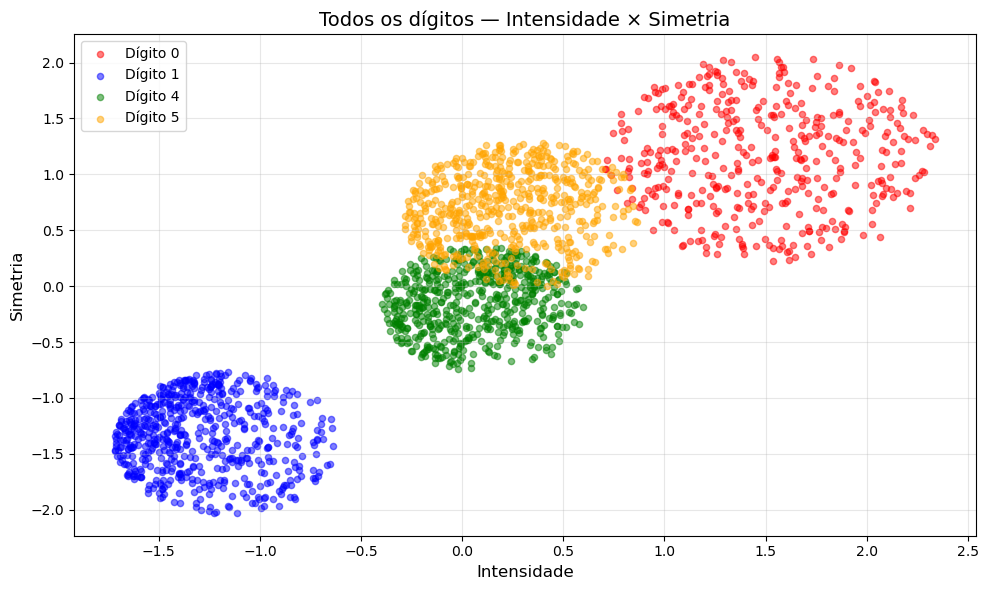

In [8]:
plt.figure(figsize=(10, 6))
cores = {0: 'red', 1: 'blue', 4: 'green', 5: 'orange'}

for digito, cor in cores.items():
    mask = df_train['label'] == digito
    plt.scatter(
        df_train[mask]['intensidade'],
        df_train[mask]['simetria'],
        c=cor, label=f'Dígito {digito}',
        s=20, alpha=0.5
    )

plt.xlabel('Intensidade', fontsize=12)
plt.ylabel('Simetria',    fontsize=12)
plt.title('Todos os dígitos — Intensidade × Simetria', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

# Parte I — Classificação Binária: Dígito 1 × Dígito 5

## 8. Filtragem do Subconjunto 1 × 5

Isolamos apenas as amostras dos dígitos **1** e **5** para treinar e avaliar classificadores binários.

In [9]:
df_train_1x5 = df_train[df_train['label'].isin([1, 5])].copy()
df_test_1x5  = df_test[df_test['label'].isin([1, 5])].copy()

print(f"Treino 1x5: {df_train_1x5.shape}")
print(f"Teste  1x5: {df_test_1x5.shape}")

Treino 1x5: (1184, 3)
Teste  1x5: (583, 3)


## 9. Visualização — Dígitos 1 × 5

Scatter plot mostrando que os dígitos 1 e 5 são **linearmente separáveis** no espaço (intensidade, simetria):
- O `1` concentra-se na região de **baixa intensidade**
- O `5` concentra-se na região de **alta intensidade**

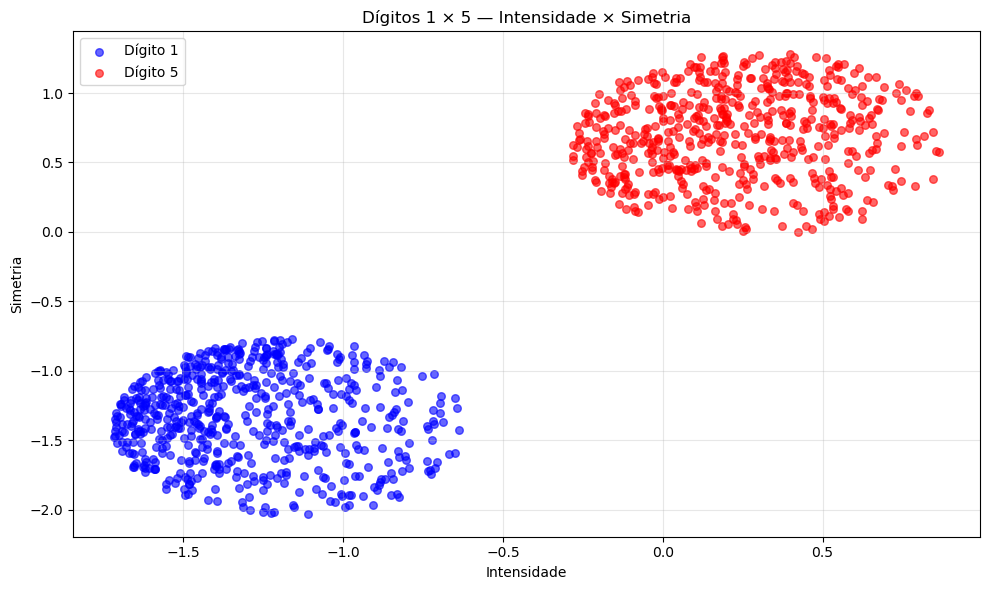

In [10]:
d1 = df_train_1x5[df_train_1x5['label'] == 1]
d5 = df_train_1x5[df_train_1x5['label'] == 5]

plt.figure(figsize=(10, 6))
plt.scatter(d1['intensidade'], d1['simetria'], c='blue', label='Dígito 1', s=30, alpha=0.6)
plt.scatter(d5['intensidade'], d5['simetria'], c='red',  label='Dígito 5', s=30, alpha=0.6)
plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Dígitos 1 × 5 — Intensidade × Simetria')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Preparação das Matrizes X e y

Montamos as matrizes para os modelos:
- **X** → `[1, intensidade, simetria]` (coluna de 1s para o **bias/w₀**)
- **y** → `+1` para dígito 1, `-1` para dígito 5

 Os modelos esperam rótulos em {+1, −1} para classificação binária.

In [11]:
# treino
X_train_1x5 = df_train_1x5[['intensidade', 'simetria']].to_numpy()
X_train_1x5 = np.c_[np.ones(X_train_1x5.shape[0]), X_train_1x5]  # adiciona bias
y_train_1x5 = np.where(df_train_1x5['label'].to_numpy() == 1, 1, -1)

# teste
X_test_1x5 = df_test_1x5[['intensidade', 'simetria']].to_numpy()
X_test_1x5 = np.c_[np.ones(X_test_1x5.shape[0]), X_test_1x5]
y_test_1x5 = np.where(df_test_1x5['label'].to_numpy() == 1, 1, -1)

print(f"X_train: {X_train_1x5.shape}, y_train: {y_train_1x5.shape}")
print(f"X_test:  {X_test_1x5.shape},  y_test:  {y_test_1x5.shape}")

X_train: (1184, 3), y_train: (1184,)
X_test:  (583, 3),  y_test:  (583,)


## 11. Funções Auxiliares

### `plotar_reta(df, w, titulo)`
Plota os dados e a **reta de decisão** definida por:

$$
w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 = 0 \implies x_2 = -\frac{w_0 + w_1 \cdot x_1}{w_2}
$$


### `avaliar_modelo(nome, y_true, y_pred, labels)`
Exibe as métricas de classificação:
- **Acurácia** — proporção de acertos totais
- **Precisão** — dos que o modelo disse ser classe X, quantos realmente são
- **Recall** — dos que realmente são classe X, quantos o modelo identificou
- **F1-Score** — média harmônica entre precisão e recall
- **Matriz de Confusão** — visualização dos acertos e erros por classe

In [12]:
def plotar_reta(df, w, titulo, digito_pos=1, digito_neg=5):
    d_pos = df[df['label'] == digito_pos]
    d_neg = df[df['label'] == digito_neg]

    plt.figure(figsize=(10, 6))
    plt.scatter(d_pos['intensidade'], d_pos['simetria'],
                c='blue', label=f'Dígito {digito_pos}', s=30, alpha=0.6)
    plt.scatter(d_neg['intensidade'], d_neg['simetria'],
                c='red',  label=f'Dígito {digito_neg}', s=30, alpha=0.6)

    x_vals = np.linspace(df['intensidade'].min(),
                     df['intensidade'].max(), 200)

    
    if w[2] != 0:
        y_vals = -(w[0] + w[1] * x_vals) / w[2]
        plt.plot(x_vals, y_vals, 'k-', linewidth=2, label='Reta de decisão')

    plt.xlabel('Intensidade')
    plt.ylabel('Simetria')
    plt.title(titulo)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def avaliar_modelo(nome, y_true, y_pred, labels):
    print(f"\n{'='*45}")
    print(f"  {nome}")
    print(f"{'='*45}")
    print(f"Acurácia : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precisão : {precision_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"F1-Score : {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues')
    plt.title(f'Matriz de Confusão — {nome}')
    plt.show()

## 12. Modelo 1 — Pocket Perceptron (1 × 5)

O **Pocket Perceptron** é uma variação do Perceptron clássico:
1. A cada iteração, executa o **PLA** (Perceptron Learning Algorithm) usando subconjuntos aleatórios entre `n_min` e `n_max` amostras
2. Mantém no "bolso" (**pocket**) os pesos que obtiveram o **menor erro** até o momento
3. Ao final, retorna os melhores pesos encontrados

 **Vantagem sobre o PLA puro**: garante convergência para uma boa solução mesmo quando os dados **não são perfeitamente separáveis**.

**Hiperparâmetros:**
- `iterations = 500`
- `n_min = 30%` dos dados, `n_max = 70%` dos dados

Treinando Pocket Perceptron: 100%|██████████| 100/100 [00:00<00:00, 617.29it/s]


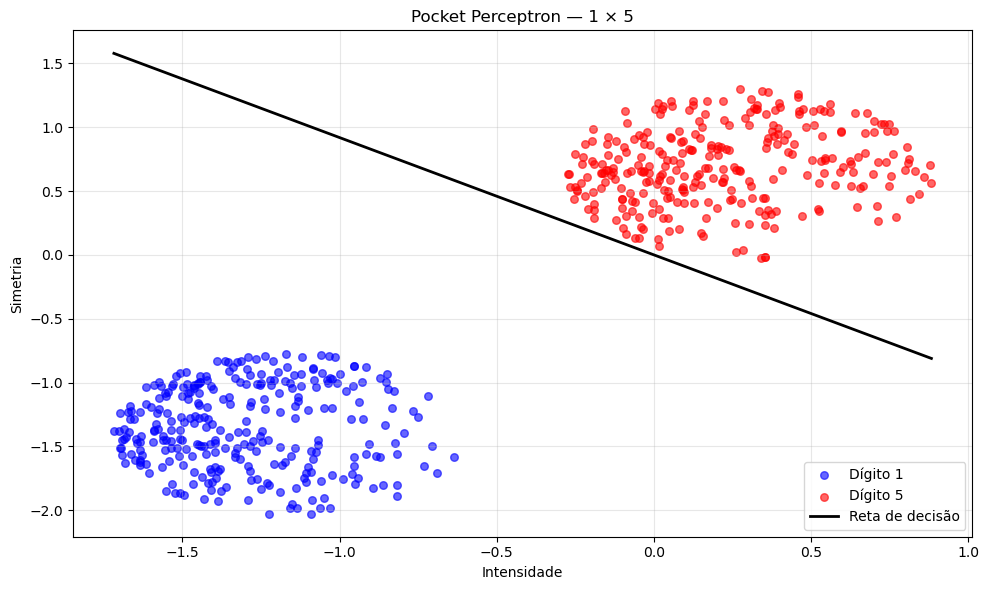


  Pocket Perceptron (1×5)
Acurácia : 1.0000
Precisão : 1.0000
Recall   : 1.0000
F1-Score : 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       292
           5       1.00      1.00      1.00       291

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



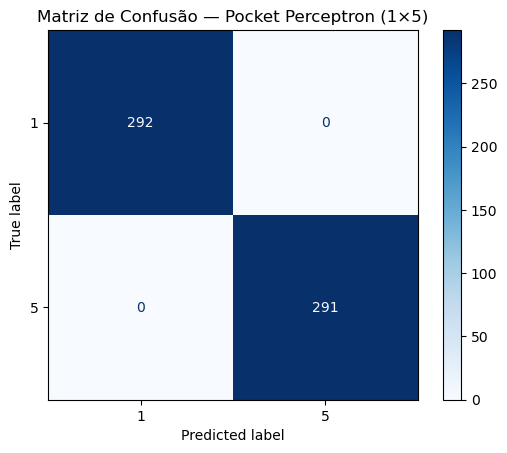

In [13]:
n_min = int(np.ceil(X_train_1x5.shape[0] * 0.3))
n_max = int(np.ceil(X_train_1x5.shape[0] * 0.7))

pp = PocketPerceptron(iterations=100, n_min=n_min, n_max=n_max, random_state=42)
pp.fit(X_train_1x5, y_train_1x5)
w_pp = pp.get_w()

y_pred_pp = pp.predict(X_test_1x5)

plotar_reta(df_test_1x5, w_pp, 'Pocket Perceptron — 1 × 5')

y_true_labels    = np.where(y_test_1x5  == 1, 1, 5)
y_pred_pp_labels = np.where(y_pred_pp   == 1, 1, 5)
avaliar_modelo("Pocket Perceptron (1×5)", y_true_labels, y_pred_pp_labels, [1, 5])

## 13. Modelo 2 — Regressão Linear como Classificador (1 × 5)

Utiliza a **pseudo-inversa** para encontrar os pesos ótimos de forma analítica (sem iterações):


$$
\mathbf{w} = (X^T X)^{-1} X^T \mathbf{y}
$$


A predição é feita pelo **sinal** da saída:

$$
\hat{y} = \text{sign}(\mathbf{w}^T \mathbf{x})
$$


 **Vantagem**: solução direta, sem necessidade de definir taxa de aprendizado ou número de iterações.
 **Limitação**: minimiza o erro quadrático, não o erro de classificação.

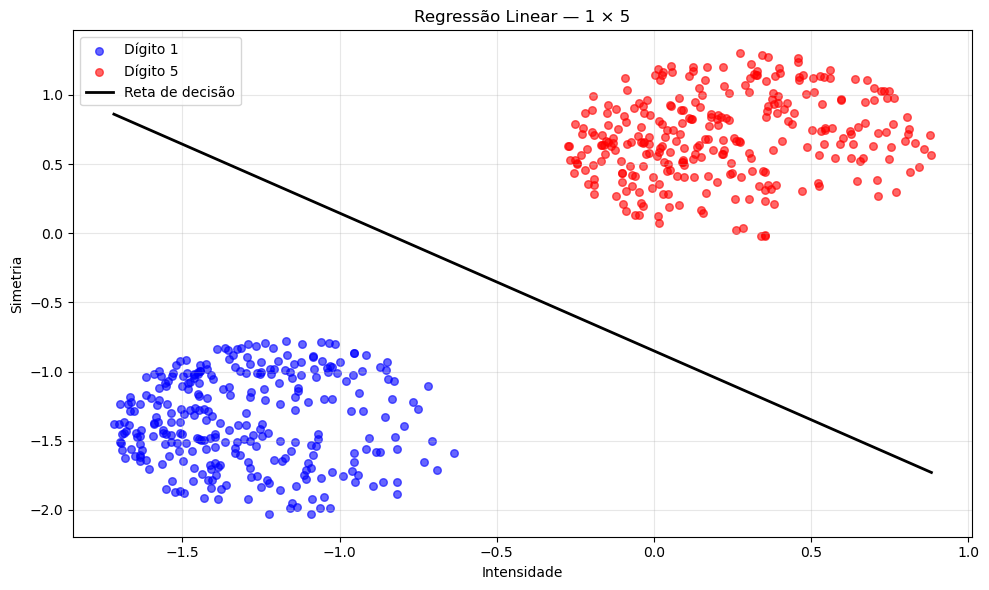


  Regressão Linear (1×5)
Acurácia : 1.0000
Precisão : 1.0000
Recall   : 1.0000
F1-Score : 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       292
           5       1.00      1.00      1.00       291

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



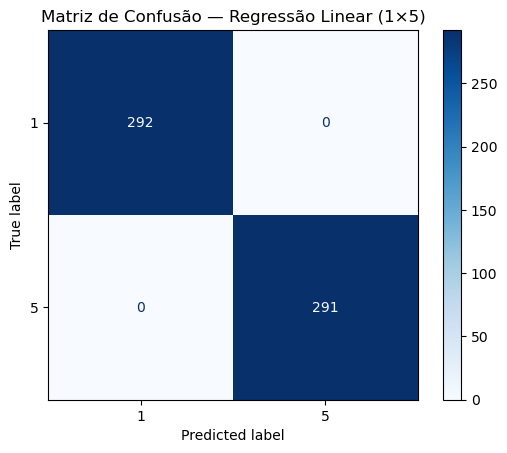

In [14]:
lr = LinearRegression()
lr.fit(X_train_1x5, y_train_1x5)
w_lr = lr.get_w()

y_pred_lr = lr.predict(X_test_1x5)

plotar_reta(df_test_1x5, w_lr, 'Regressão Linear — 1 × 5')

y_pred_lr_labels = np.where(y_pred_lr == 1, 1, 5)
avaliar_modelo("Regressão Linear (1×5)", y_true_labels, y_pred_lr_labels, [1, 5])

## 14. Modelo 3 — Regressão Logística (1 × 5)

Utiliza **Gradiente Descendente Estocástico (SGD)** para minimizar a função de custo **cross-entropy**:


$$
E_{in}(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^{N} \ln\!\Big(1 + e^{-y_n \cdot \mathbf{w}^T \mathbf{x}_n}\Big) + \frac{\lambda}{2}\|\mathbf{w}\|^2
$$


O termo $\frac{\lambda}{2}\|\mathbf{w}\|^2$ é a **regularização L2 (weight decay)**, que penaliza pesos grandes e ajuda a evitar overfitting.

**Hiperparâmetros:**
- `eta = 0.1` (taxa de aprendizado)
- `iterations = 80.000`
- `batch_size = 512`
- `λ = 1e-4` (weight decay)

Treinando Regressão Logística: 100%|██████████| 1000/1000 [00:00<00:00, 6024.22it/s]


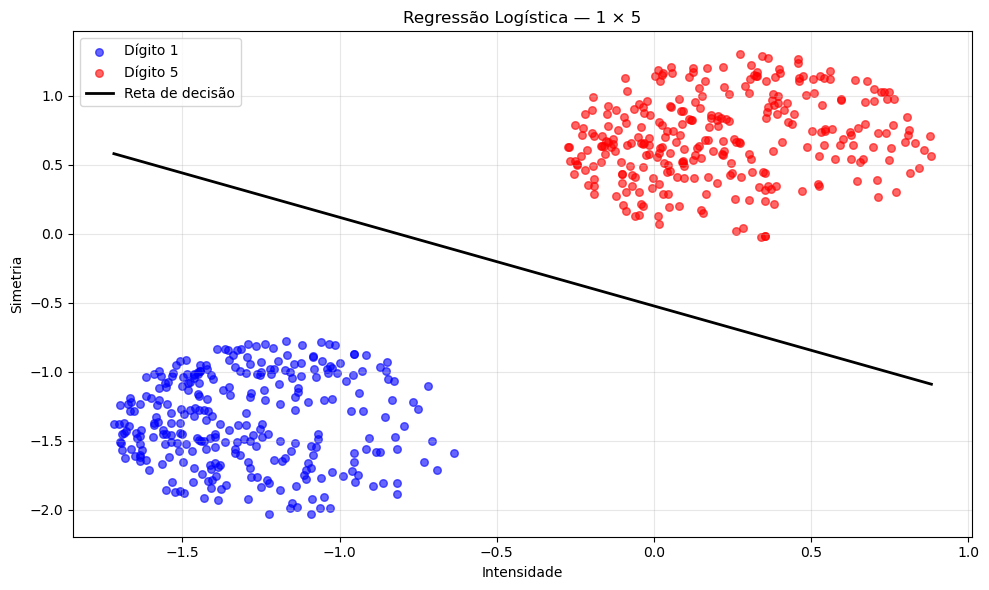


  Regressão Logística (1×5)
Acurácia : 1.0000
Precisão : 1.0000
Recall   : 1.0000
F1-Score : 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       292
           5       1.00      1.00      1.00       291

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



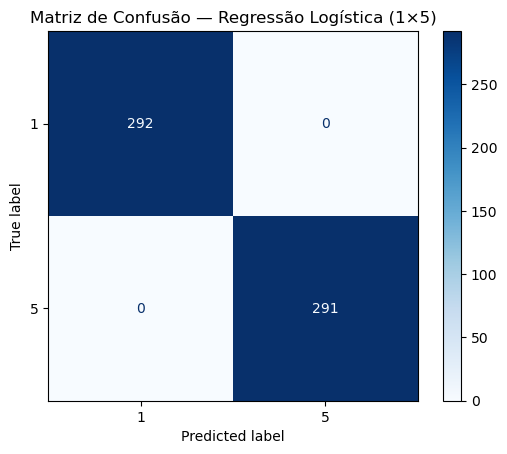

In [15]:
rlog = LogisticRegression(eta=0.1, iterations=1000, batch_size=512)
rlog.fit(X_train_1x5, y_train_1x5, lamb=1e-4)  # weight decay ativado
w_rlog = rlog.get_w()

y_pred_rlog = rlog.predict(X_test_1x5)

plotar_reta(df_test_1x5, w_rlog, 'Regressão Logística — 1 × 5')

y_pred_rlog_labels = np.where(y_pred_rlog == 1, 1, 5)
avaliar_modelo("Regressão Logística (1×5)", y_true_labels, y_pred_rlog_labels, [1, 5])

---

# Parte II — Classificação Multiclasse: One vs All (0, 1, 4, 5)

## 15. Preparação dos Dados — 4 Classes

Agora usamos **todas as amostras** dos dígitos {0, 1, 4, 5}.

A estratégia **One vs All (OvA)** funciona assim:
1. Para cada dígito $d$ nos dígitos prioritários `[1, 0, 4]`, treina-se um classificador binário: **dígito $d$ (+1) vs todos os outros (−1)**
2. Na predição, cada classificador vota; ganha quem tiver maior **confiança** (score)
3. Se nenhum classificador responde +1, o dígito padrão (`5`) é atribuído



In [16]:
# X e y com todos os 4 dígitos
X_train_all = df_train[['intensidade', 'simetria']].to_numpy()
X_train_all = np.c_[np.ones(X_train_all.shape[0]), X_train_all]
y_train_all = df_train['label'].to_numpy()

X_test_all = df_test[['intensidade', 'simetria']].to_numpy()
X_test_all = np.c_[np.ones(X_test_all.shape[0]), X_test_all]
y_test_all = df_test['label'].to_numpy()

digitos = [1, 0, 4, 5]  # 1 sai primeiro por ser mais separável; 5 é o padrão

print(f"X_train: {X_train_all.shape}, y_train: {y_train_all.shape}")
print(f"X_test:  {X_test_all.shape},  y_test:  {y_test_all.shape}")
print(f"Distribuição treino: {dict(zip(*np.unique(y_train_all, return_counts=True)))}")

X_train: (2186, 3), y_train: (2186,)
X_test:  (1115, 3),  y_test:  (1115,)
Distribuição treino: {0: 425, 1: 608, 4: 577, 5: 576}


## 16. Funções de Visualização — One vs All

Funções para plotar os dados com as **3 retas de decisão** (uma por classificador OvA), cada uma separando um dígito do restante.

In [17]:
def calculate_y(x, w):
    return -(w[0] + w[1] * x) / w[2]

def plotar_ova(df, digitos, titulo, W):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    cores_digitos = {0: 'red', 1: 'blue', 4: 'green', 5: 'orange'}
    for digito in digitos:
        d = df[df['label'] == digito]
        ax.scatter(d['intensidade'], d['simetria'],
                   color=cores_digitos[digito], label=f'Dígito {digito}', s=20, alpha=0.5)
    
    cores_retas = ['crimson', 'royalblue', 'forestgreen']
    
    x_vals = np.linspace(df['intensidade'].min() - 0.2, df['intensidade'].max() + 0.2, 300)
    for i, w in enumerate(W):
        y_vals = calculate_y(x_vals, w)
        ax.plot(x_vals, y_vals, color=cores_retas[i], linestyle='-',
                linewidth=2, label=f'{digitos[i]} vs resto')
    
    ax.set_xlim([df['intensidade'].min() - 0.2, df['intensidade'].max() + 0.2])
    ax.set_ylim([df['simetria'].min() - 0.2, df['simetria'].max() + 0.2])
    ax.set_xlabel('Intensidade', fontsize=12)
    ax.set_ylabel('Simetria', fontsize=12)
    ax.set_title(titulo, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 17. Pocket Perceptron — One vs All

Treinamos **3 Pocket Perceptrons** (um para cada dígito prioritário vs resto) com `20.000 iterações` cada.

 Tempo de treinamento maior pois o problema multiclasse é mais difícil e o dataset completo é maior.

Treinando Pocket Perceptron: 100%|██████████| 20000/20000 [02:00<00:00, 165.34it/s]


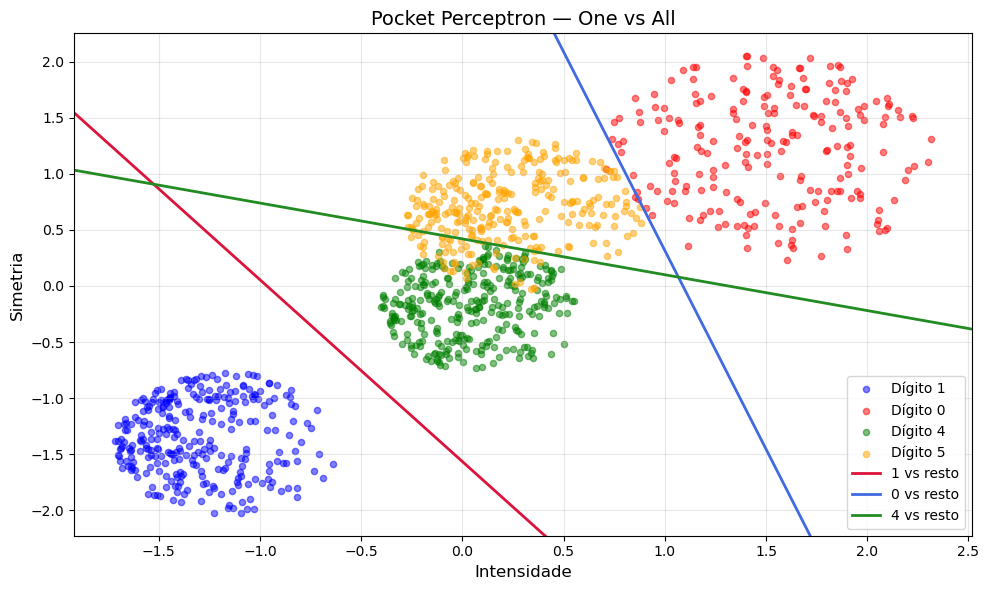


  Pocket Perceptron (One vs All)
Acurácia : 0.9596
Precisão : 0.9637
Recall   : 0.9596
F1-Score : 0.9594
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       218
           1       1.00      1.00      1.00       292
           4       0.88      1.00      0.94       314
           5       0.99      0.86      0.92       291

    accuracy                           0.96      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



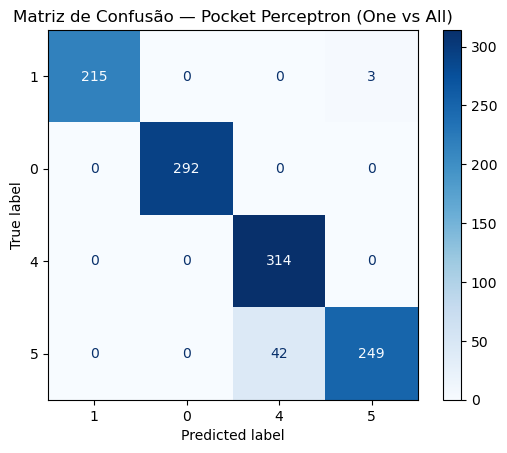

In [18]:
n_min = int(np.ceil(X_train_all.shape[0] * 0.3))
n_max = int(np.ceil(X_train_all.shape[0] * 0.7))

ova_pp = OneVsAll(PocketPerceptron(iterations=20000, n_min=n_min, n_max=n_max, random_state=42), digitos)
ova_pp.execute(X_train_all, y_train_all)
y_pred_ova_pp = ova_pp.predict_digit(X_test_all)

plotar_ova(df_test, digitos, 'Pocket Perceptron — One vs All', ova_pp.all_w)
avaliar_modelo("Pocket Perceptron (One vs All)", y_test_all, y_pred_ova_pp, digitos)

## 18. Regressão Linear — One vs All

Treinamos **3 regressões lineares** via pseudo-inversa. Solução analítica instantânea para cada subproblema.

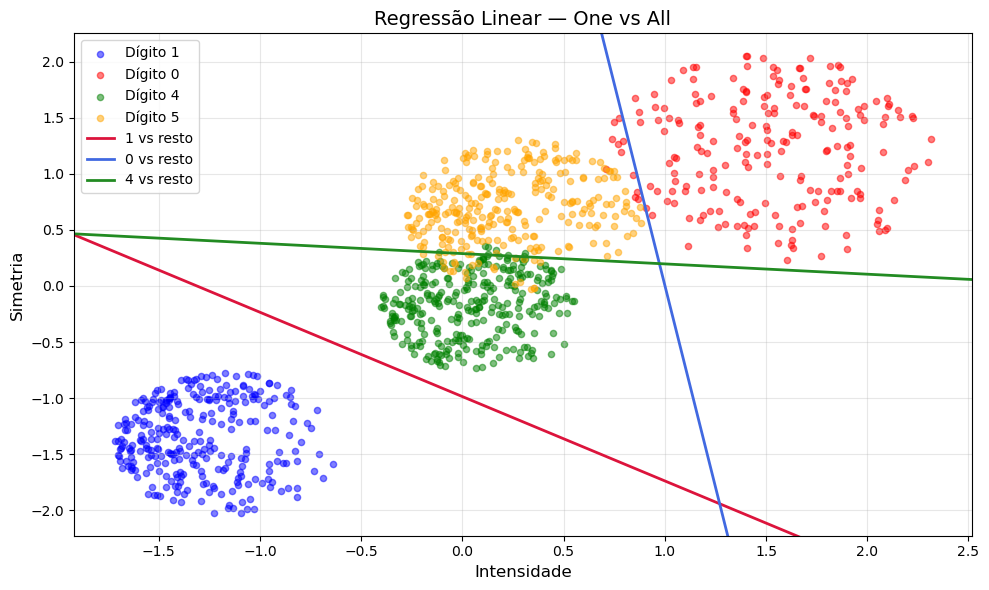


  Regressão Linear (One vs All)
Acurácia : 0.9614
Precisão : 0.9622
Recall   : 0.9614
F1-Score : 0.9615
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       218
           1       1.00      1.00      1.00       292
           4       0.93      0.97      0.95       314
           5       0.93      0.92      0.93       291

    accuracy                           0.96      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



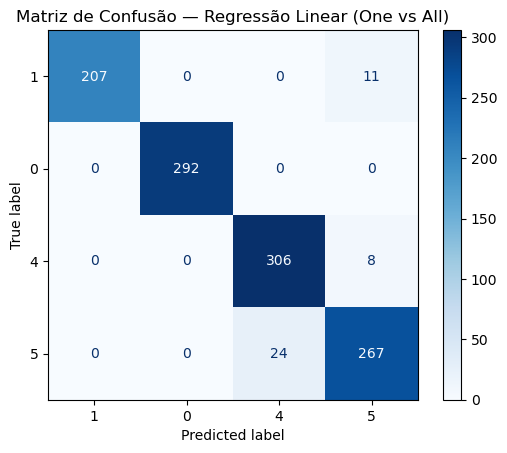

In [19]:
ova_lr = OneVsAll(LinearRegression(), digitos)
ova_lr.execute(X_train_all, y_train_all)
y_pred_ova_lr = ova_lr.predict_digit(X_test_all)

plotar_ova(df_test, digitos, 'Regressão Linear — One vs All', ova_lr.all_w)
avaliar_modelo("Regressão Linear (One vs All)", y_test_all, y_pred_ova_lr, digitos)

## 19. Regressão Logística — One vs All

Treinamos **3 regressões logísticas** com SGD.

**Hiperparâmetros:**
- `eta = 0.1`, `iterations = 3.500.000`, `batch_size = 512`, `λ = 1e-6`

 O modelo implementa **early stopping**: para automaticamente quando a variação do custo entre iterações é menor que um limiar (`tol`), indicando convergência.

Treinando Regressão Logística: 100%|██████████| 10000/10000 [00:01<00:00, 8764.29it/s]


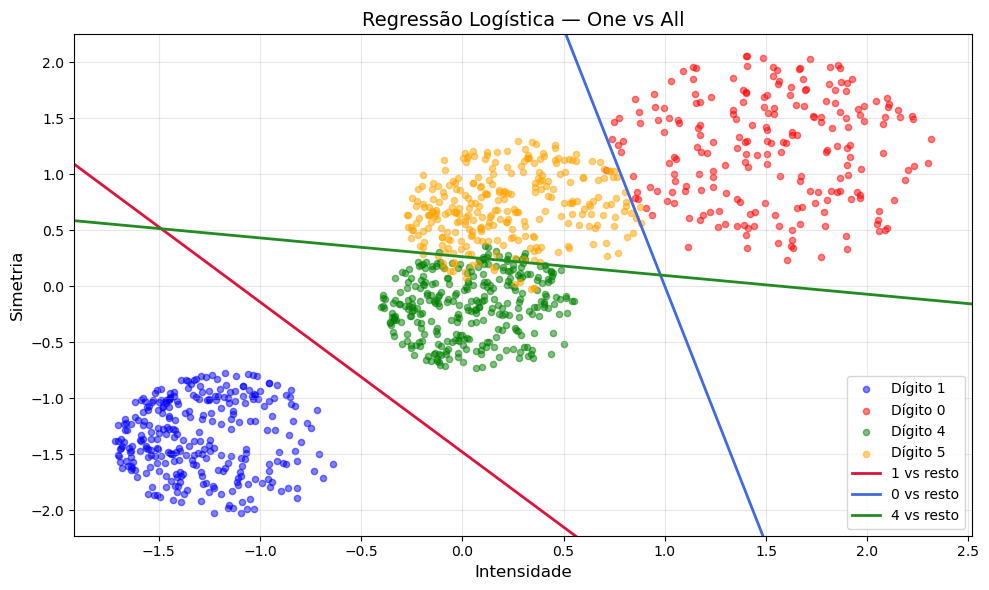


  Regressão Logística (One vs All)
Acurácia : 0.9659
Precisão : 0.9659
Recall   : 0.9659
F1-Score : 0.9659
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       218
           1       1.00      1.00      1.00       292
           4       0.94      0.95      0.94       314
           5       0.94      0.93      0.93       291

    accuracy                           0.97      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.97      0.97      0.97      1115



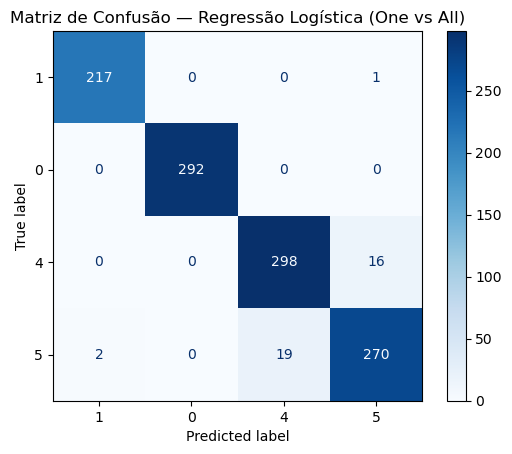

In [20]:
ova_rlog = OneVsAll(LogisticRegression(eta=0.1, iterations=10000, batch_size=512), digitos)
ova_rlog.execute(X_train_all, y_train_all, lamb=1e-6)  # weight decay ativado
y_pred_ova_rlog = ova_rlog.predict_digit(X_test_all)

plotar_ova(df_test, digitos, 'Regressão Logística — One vs All', ova_rlog.all_w)
avaliar_modelo("Regressão Logística (One vs All)", y_test_all, y_pred_ova_rlog, digitos)

---

## 20. Comparação Final dos Modelos

### Resumo dos resultados no cenário **One vs All** (4 classes):

Os resultados detalhados (acurácia, F1-score e matriz de confusão) de cada modelo estão nas seções anteriores. A célula abaixo consolida e compara os valores automaticamente.



             COMPARAÇÃO FINAL — ONE VS ALL             
Modelo                      Acurácia   F1-Score
-------------------------------------------------------
Pocket Perceptron             95.96%     95.94%
Regressão Linear              96.14%     96.15%
Regressão Logística           96.59%     96.59%


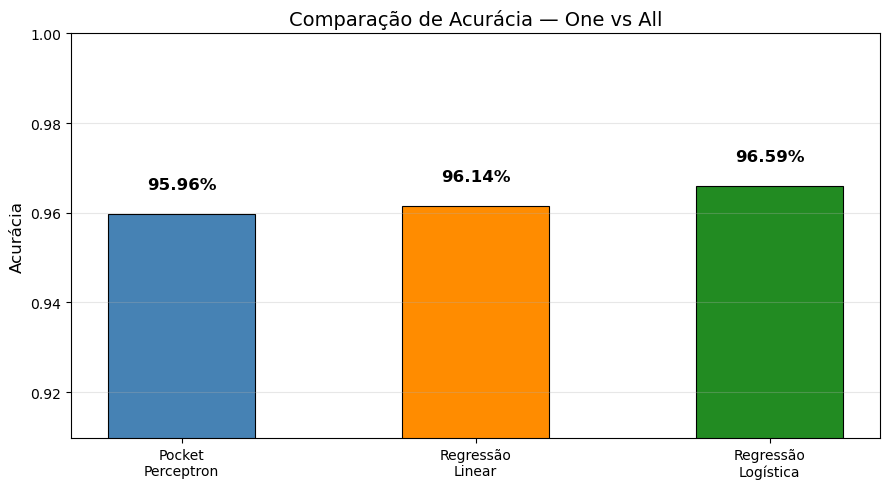

In [21]:
resultados = {
    'Pocket Perceptron':   accuracy_score(y_test_all, y_pred_ova_pp),
    'Regressão Linear':    accuracy_score(y_test_all, y_pred_ova_lr),
    'Regressão Logística': accuracy_score(y_test_all, y_pred_ova_rlog),
}

f1s = {
    'Pocket Perceptron':   f1_score(y_test_all, y_pred_ova_pp,   average='weighted', zero_division=0),
    'Regressão Linear':    f1_score(y_test_all, y_pred_ova_lr,   average='weighted', zero_division=0),
    'Regressão Logística': f1_score(y_test_all, y_pred_ova_rlog, average='weighted', zero_division=0),
}

print("=" * 55)
print(f"{'COMPARAÇÃO FINAL — ONE VS ALL':^55}")
print("=" * 55)
print(f"{'Modelo':<25} {'Acurácia':>10} {'F1-Score':>10}")
print("-" * 55)
for nome in resultados:
    print(f"{nome:<25} {resultados[nome]*100:>9.2f}% {f1s[nome]*100:>9.2f}%")
print("=" * 55)

modelos = ['Pocket\nPerceptron', 'Regressão\nLinear', 'Regressão\nLogística']
acuracias = list(resultados.values())
cores = ['steelblue', 'darkorange', 'forestgreen']

plt.figure(figsize=(9, 5))
bars = plt.bar(modelos, acuracias, color=cores, width=0.5, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars, acuracias):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.005,
             f'{val*100:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim([max(0, min(acuracias) - 0.05), 1.00])
plt.ylabel('Acurácia', fontsize=12)
plt.title('Comparação de Acurácia — One vs All', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()